# Predicting Titanic Passenger Survival

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Exploratory data analysis (inspect dataset, evaluate distribution of variables to find possible correlations)
### Data cleaning to handle/remove missing values
### Build model and test

In [2]:
training = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

training.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [3]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [4]:
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [5]:
df_num = training[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = training[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

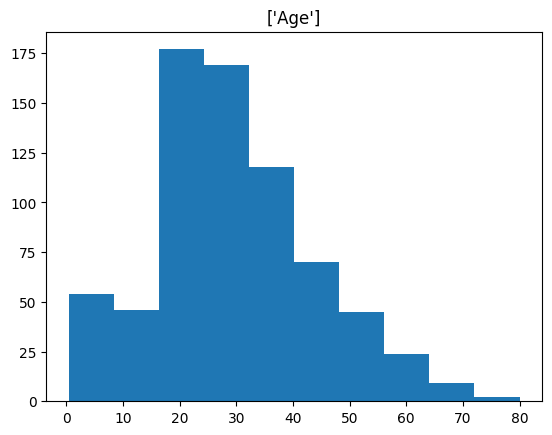

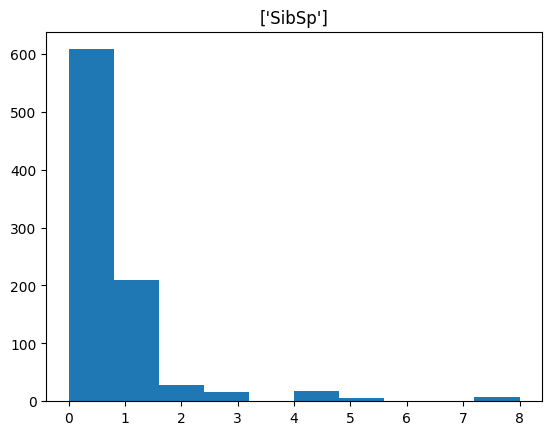

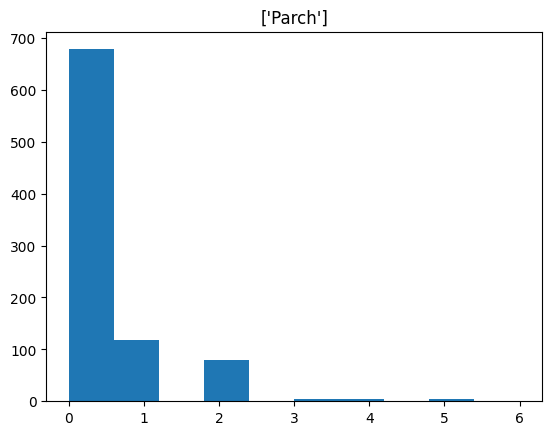

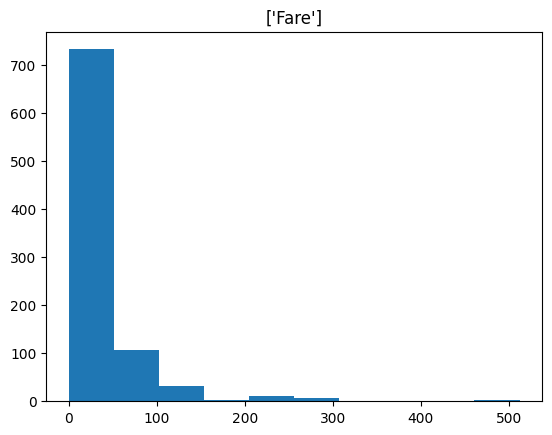

In [6]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title([i])
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

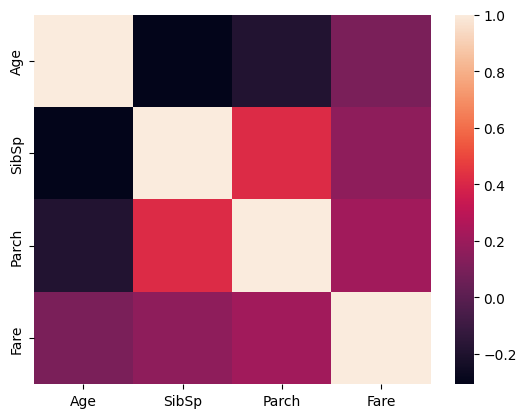

In [7]:
print(df_num.corr())
sns.heatmap(df_num.corr())

In [8]:
pd.pivot_table(training, index = 'Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


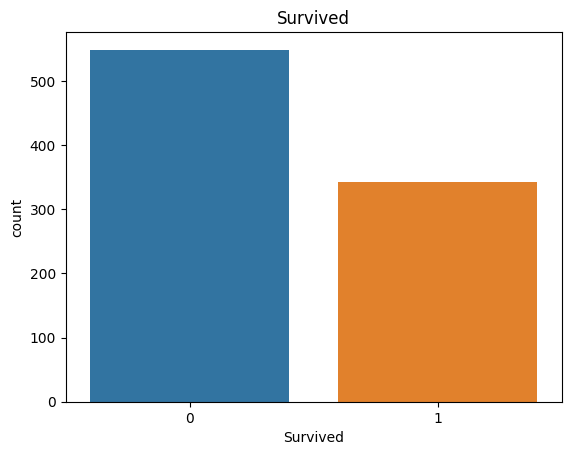

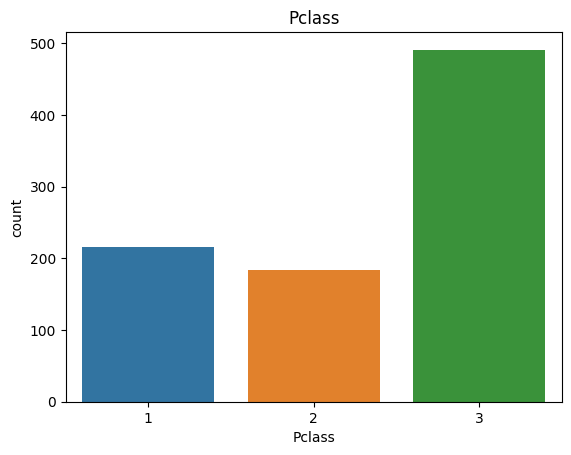

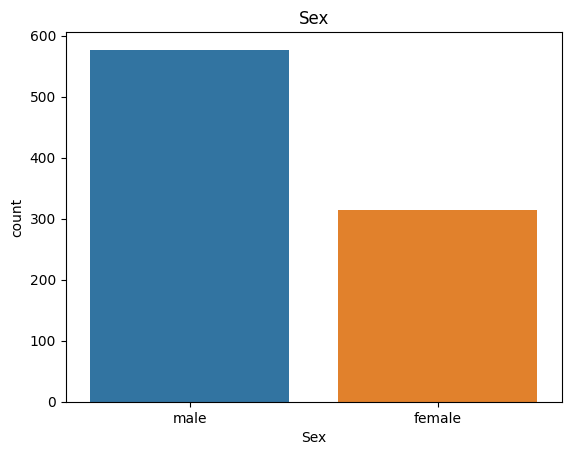

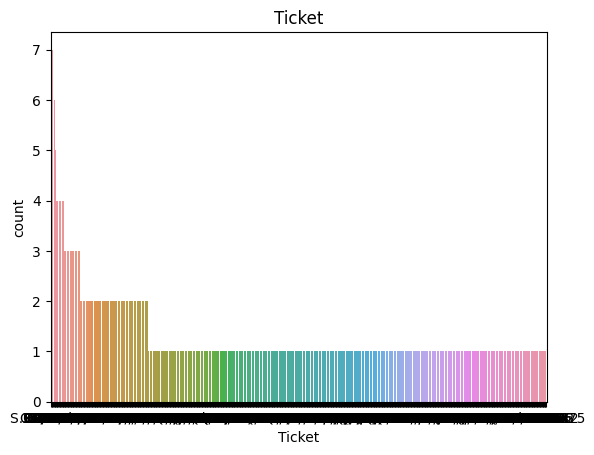

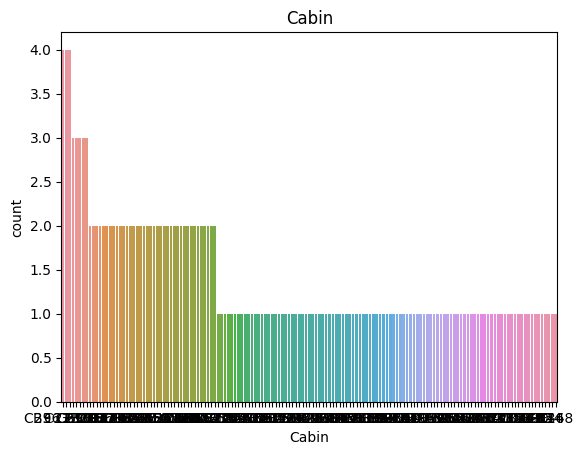

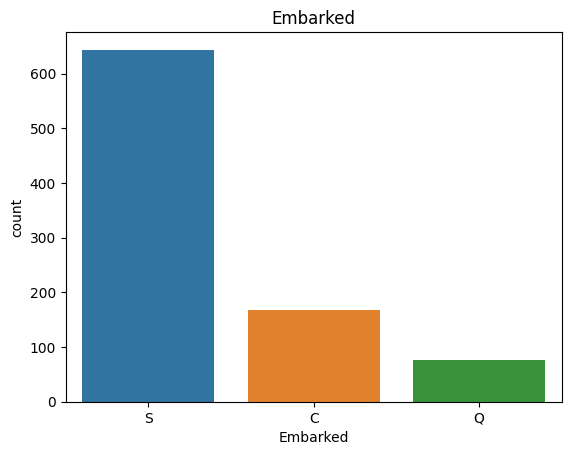

In [9]:
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index, y=df_cat[i].value_counts())
    plt.title(i)
    plt.show()

In [10]:
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket', aggfunc = 'count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket', aggfunc = 'count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket', aggfunc = 'count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


For the sake of time, and because it's a bit beyond my own knowledge, I skipped the feature engineering for cabin letter/ticket letter/name, so I'm not including those in my model.

1. Drop null values from embarked
2. include only relevant variables ('Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked')
3. Categorical transforms on training and test dataset (see original video for admonitions against training on combined data outside competition environment)
4. Impute data with mean or median for fare and age
5. Normalize distribution for fare using log
6. Scale data 0-1 with standard scaler

(889,)

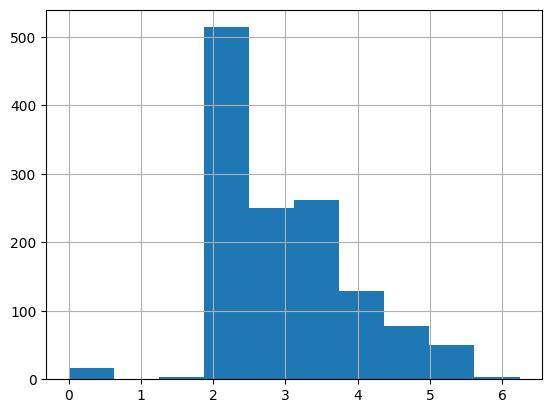

In [13]:
# impute nulls for continuous data
all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Fare = all_data.Fare.fillna(training.Fare.mean())

# drop null 'embarked' rows
all_data.dropna(subset=['Embarked'], inplace=True)

# logarithmic normalization of 'fare'
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# dummy variables from categories
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'train_test']])

X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis=1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis=1)

y_train = all_data[all_data.train_test==1].Survived
y_train.shape